In [23]:
import matplotlib.pyplot as plt
import numpy as np
import json
from lib import dwt, huffman, ezw, size_amp, enc_dec, entropy
import cv2

In [24]:
# define var
img_path = '/home/fanqy/research-temp/eee5347/final-project/img/image1.512'
quant_step = 32
encoded_filename = 'data/lena_encoded.bin'
reconstructed_filename = 'data/lena_reconstructed.png'

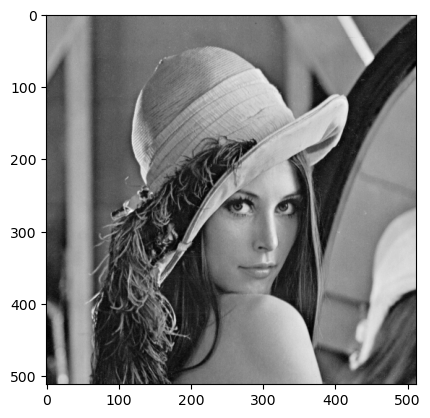

In [25]:
with open(img_path, 'rb') as f:
    data = f.read()
    data = list(data)
    # reshape data to numpy 512x512
    data = np.array(data)
    img = data.reshape((512, 512))
    plt.imshow(img, cmap='gray')

In [26]:
def imageEncoder(img_path, quant_step, encoded_filename):
    # open /home/fanqy/research-temp/eee5347/final-project/image1.512
    with open(img_path, 'rb') as f:
        data = f.read()
        data = list(data)
        # reshape data to numpy 512x512
        data = np.array(data)
        img = data.reshape((512, 512))
        # plt.imshow(img, cmap='gray')

    # DWT
    l5_decomp = dwt.decomposition_to_specify_level(img, 5)

    # QUANT
    l5_decomp_quant = np.round(l5_decomp / quant_step)
    
    # ezw_encode
    # enumerate the img[0,16:0,16]
    root_nodes = [[None for _ in range(16)] for _ in range(16)]
    for i in range(0, 16):
        for j in range(0, 16):
            # in order of quadrant 1,3,4
            child_1 = ezw.build_tree(l5_decomp_quant, 1, (i,j+16), 1, None)
            child_3 = ezw.build_tree(l5_decomp_quant, 1, (i+16,j), 3, None)
            child_4 = ezw.build_tree(l5_decomp_quant, 1, (i+16,j+16), 4, None)
            root_nodes[i][j] = ezw.EZWTree(l5_decomp_quant[i, j], 0, 2, (i,j), [child_1, child_3, child_4], None) # type: ignore
            child_1.parent = root_nodes[i][j] # type: ignore
            child_3.parent = root_nodes[i][j] # type: ignore
            child_4.parent = root_nodes[i][j] # type: ignore

    # dpr
    dpr_list= ezw.enc_dp_sp(root_nodes)

    # size amplitude representation
    result_size = []
    result_amplitude = []
    for i in range(16):
        for j in range(16):
            rs, ra = size_amp.size_amplitude_single_list(dpr_list[i][j])
            result_size = result_size + rs
            result_amplitude = result_amplitude + ra

    result_amplitude_str_lf = ''.join(str(i) for i in result_amplitude)

    # encode the top 16*16
    top_16_16 = l5_decomp_quant[0:16, 0:16].flatten().astype(int)
    top_16_16_diff = np.diff(top_16_16)
    top_16_16_diff = np.insert(top_16_16_diff, 0, top_16_16[0]).tolist()

    rs_16_16, ra_16_16 = size_amp.size_amplitude_single_list(top_16_16_diff)
    ra_16_16_str = ''.join(str(i) for i in ra_16_16)

    # huffman encode
    huffman_dict = huffman.huffman_encode(result_size + rs_16_16)
    huffman_encoded_result_size = huffman.encode_data(result_size, huffman_dict)
    huffman_encoded_rs_16_16 = huffman.encode_data(rs_16_16, huffman_dict)

    code_table = huffman_dict

    # Convert the code table to binary
    code_table_binary = enc_dec.convert_code_table_to_binary(code_table)

    quant_step_binary = enc_dec.float_to_binary_str(float(quant_step))

    # Combine the code table and the encoded data
    # Define a separator
    separator = '11110000101001011111000010100101'

    # Combine
    combined_data =  code_table_binary + separator + quant_step_binary + separator + enc_dec.pad_encoded_data(huffman_encoded_result_size) + separator + enc_dec.pad_encoded_data(result_amplitude_str_lf) + separator + enc_dec.pad_encoded_data(huffman_encoded_rs_16_16) + separator + enc_dec.pad_encoded_data(ra_16_16_str)

    # Write the combined data to file
    enc_dec.write_to_binary_file(combined_data, encoded_filename)

    # return bpp
    return len(combined_data) / (512 * 512)

In [27]:
imageEncoder(img_path, quant_step, encoded_filename)

0.40093994140625

## Setup a server to host the encoded data

In [20]:
# serve the data
# !python -m http.server --directory /home/fanqy/research-temp/eee5347/final-project/data

Serving HTTP on 0.0.0.0 port 8000 (http://0.0.0.0:8000/) ...
10.20.8.246 - - [31/May/2023 15:21:40] "GET /lena_encoded.bin HTTP/1.1" 200 -
^C

Keyboard interrupt received, exiting.


In [30]:
def imageDecoder(encoded_filename, img_path, original_img):

    separator = '11110000101001011111000010100101'

    # Read the binary data from the file
    combined_data = enc_dec.read_from_binary_file(encoded_filename)

    # Split the combined data into the code table and the encoded data

    code_table_binary, quant_step_binary, recon_huffman_encoded_result_size, recon_encoded_data_lf, recon_huffman_encoded_rs_16_16, recon_ra_16_16_str = enc_dec.split_data(combined_data, separator)

    # Convert the binary code table back to a dictionary
    code_table = enc_dec.convert_binary_to_code_table(code_table_binary)

    # Convert the quantization step from binary to decimal
    quant_step = enc_dec.binary_str_to_float(quant_step_binary)

    # Decode the encoded data
    recon_result_size = enc_dec.decode_data_with_huffman(recon_huffman_encoded_result_size, code_table)
    recon_result_amplitude_str_lf = enc_dec.decode_data_plain(recon_encoded_data_lf)
    recon_rs_16_16 = enc_dec.decode_data_with_huffman(recon_huffman_encoded_rs_16_16, code_table)
    recon_ra_16_16_str = enc_dec.decode_data_plain(recon_ra_16_16_str)

    # recon dpr list
    recon_dpr_list = size_amp.size_amplitude_to_2D_list_optimized(recon_result_size, recon_result_amplitude_str_lf)

    # put the hf band back
    recon_img = np.zeros((512,512)).astype('float64')
    recon_root_nodes = [[None for _ in range(16)] for _ in range(16)]
    for i in range(0, 16):
        for j in range(0, 16):
            # in order of quadrant 1,3,4
            child_1 = ezw.build_tree(recon_img, 1, (i,j+16), 1, None)
            child_3 = ezw.build_tree(recon_img, 1, (i+16,j), 3, None)
            child_4 = ezw.build_tree(recon_img, 1, (i+16,j+16), 4, None)
            recon_root_nodes[i][j] = ezw.EZWTree(recon_img[i, j], 0, 2, (i,j), [child_1, child_3, child_4], None) # type: ignore
            child_1.parent = recon_root_nodes[i][j] # type: ignore
            child_3.parent = recon_root_nodes[i][j] # type: ignore
            child_4.parent = recon_root_nodes[i][j] # type: ignore
    
    recon_img = ezw.dec_dp_sp(recon_dpr_list, recon_root_nodes, recon_img)

    # decode top 16*16
    recon_top_16_16_diff = size_amp.size_amplitude_to_2D_list(recon_rs_16_16, recon_ra_16_16_str)[0][0]

    recon_top_16_16 = np.zeros(256).astype('int')
    recon_top_16_16[0] = recon_top_16_16_diff[0]
    for i in range(1, 256):
        recon_top_16_16[i] = recon_top_16_16[i-1] + recon_top_16_16_diff[i]
    # reshape to 16*16
    recon_top_16_16 = recon_top_16_16.reshape((16,16))

    # put top 16*16 back
    recon_img[0:16, 0:16] = recon_top_16_16

    # reverse quantization
    recon_img_after_quant = recon_img * quant_step

    # reconstruct the image
    l5_recon_img_after_quant = dwt.reconstruction_from_specify_level(recon_img_after_quant, 5)

    plt.imshow(l5_recon_img_after_quant, cmap='gray')
    plt.colorbar()

    # save the image use cv2, png
    cv2.imwrite(img_path, l5_recon_img_after_quant)

    # read original image
    with open(original_img, 'rb') as f:
        data = f.read()
        data = list(data)
        # reshape data to numpy 512x512
        data = np.array(data)
        original_img = data.reshape((512, 512))

    # calculate psnr
    mse = np.sum(np.square(original_img - l5_recon_img_after_quant)) / (512*512)
    psnr = 10 * np.log10(255*255/mse)
    
    return psnr


27.15495431290286

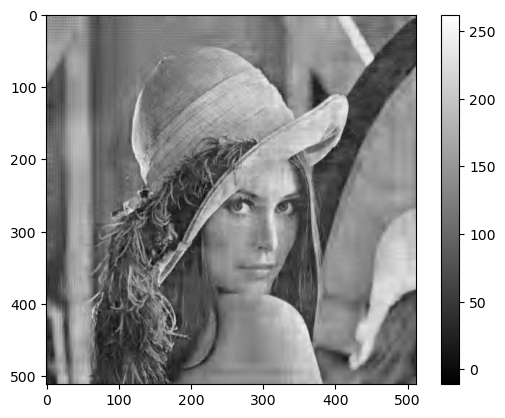

In [31]:
imageDecoder(encoded_filename, reconstructed_filename, img_path)

## Plot

In [ ]:
raise Exception('Please do not run the following cell. They are only for plotting the results.')

Exception: Please do not run the following cell. It is only for plotting the results.

In [32]:
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm, trange

In [33]:
# create a pandas table, with four columns: quant_step, bpp, psnr, and img_name
df = pd.DataFrame(columns=['quant_step', 'bpp', 'psnr', 'img_name'])
img_prefix = "/home/fanqy/research-temp/eee5347/final-project/img/image"

In [34]:
# test quantization step from 0.01 to 100 (use log)
quant_step_list = np.logspace(-3, 2, 100)

In [ ]:
df_row_count = 0
for j in trange(5):
    img_name = img_prefix + str(j+1) + '.512'
    for i in trange(len(quant_step_list)):
        bpp = imageEncoder(img_name, quant_step_list[i], encoded_filename)
        psnr = imageDecoder(encoded_filename, reconstructed_filename, img_name)
        # add quant_step, bpp, psnr, and img_name to the pandas table
        df.loc[df_row_count] = [quant_step_list[i], bpp, psnr, 'img'+str(j+1)]
        # print(img_name, quant_step_list[i], bpp, psnr)
        df_row_count += 1

In [ ]:
# save the bpp and psnr to csv
# np.savetxt('bpp_and_psnr.csv', bpp_and_psnr, delimiter=',')

# read from csv
# bpp_and_psnr = np.loadtxt('bpp_and_psnr.csv', delimiter=',')

In [ ]:
df_backup = df.copy()

In [35]:
# save df to file
# df.to_csv('bpp_and_psnr.csv')
# read df
df = pd.read_csv('bpp_and_psnr.csv')

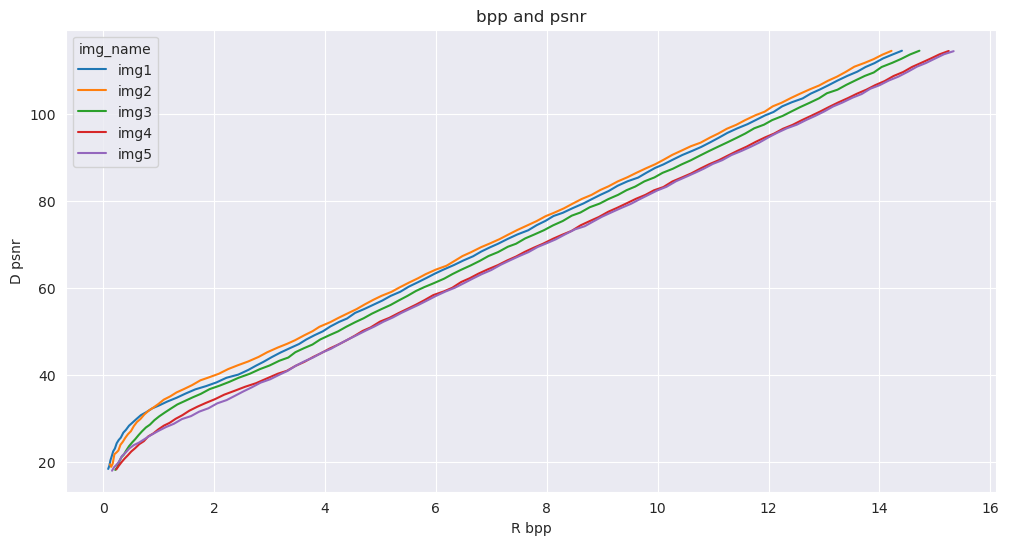

In [39]:
# seaborn plot the bpp and psnr, for each image
# set figure size
plt.figure(figsize=(12, 6))
sns.lineplot(x='bpp', y='psnr', hue='img_name', data=df)
# set y axis name
plt.ylabel('D psnr')
# set x axis name
plt.xlabel('R bpp')
# y log scale
# plt.yscale('log')
# sns set style
sns.set_style("darkgrid")
plt.title('bpp and psnr')
# save plot as svg
plt.savefig('bpp_and_psnr.svg', format='svg')

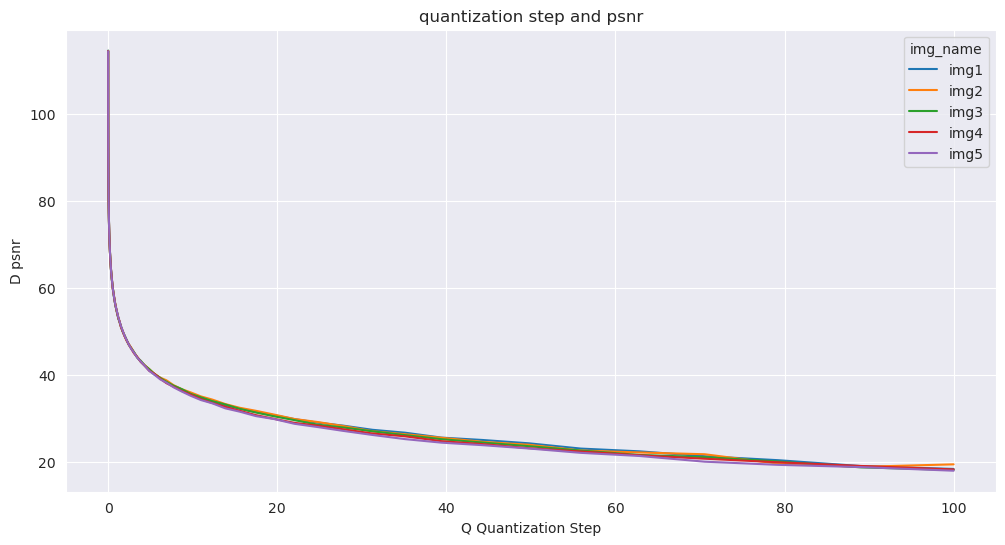

In [40]:
# seaborn plot the bpp and psnr, for each image
# set figure size
plt.figure(figsize=(12, 6))
sns.lineplot(x='quant_step', y='psnr', hue='img_name', data=df)
# set y axis name
plt.ylabel('D psnr')
# set x axis name
plt.xlabel('Q Quantization Step')
# y log scale
# plt.yscale('log')
# sns set style
sns.set_style("darkgrid")
plt.title('quantization step and psnr')
plt.savefig('qs_and_psnr.svg', format='svg')

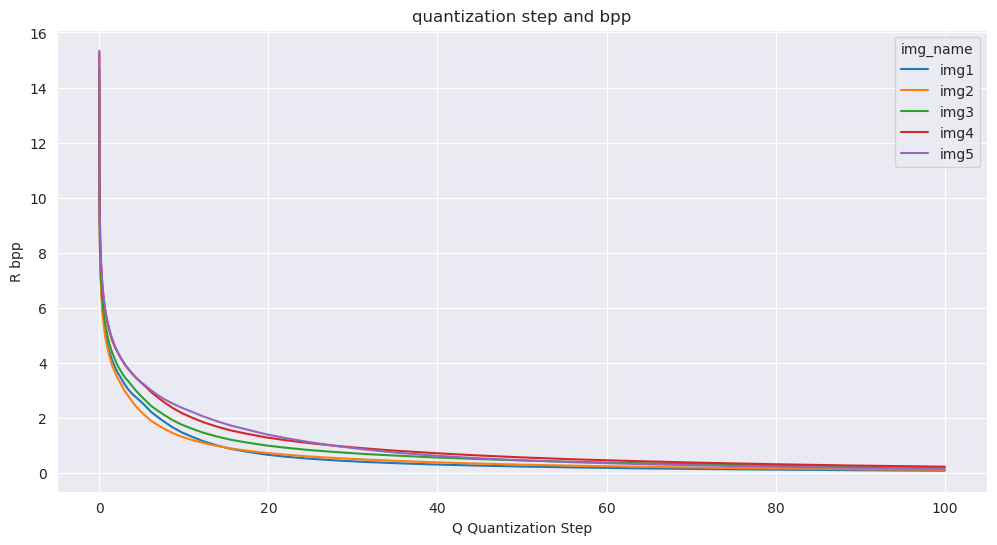

In [41]:
# seaborn plot the bpp and psnr, for each image
# set figure size
plt.figure(figsize=(12, 6))
sns.lineplot(x='quant_step', y='bpp', hue='img_name', data=df)
# set y axis name
plt.ylabel('R bpp')
# set x axis name
plt.xlabel('Q Quantization Step')
# y log scale
# plt.yscale('log')
# sns set style
sns.set_style("darkgrid")
plt.title('quantization step and bpp')
plt.savefig('qs_and_bpp.svg', format='svg')

## Plot some samples

In [ ]:
quant_step_list_sample = np.logspace(-2, 2, 5)

In [ ]:
quant_step_list_sample

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [ ]:
# init a 5*5 list to store the image
img_list = [[None for i in range(5)] for j in range(5)]
psnr_list = [[None for i in range(5)] for j in range(5)]
bpp_list = [[None for i in range(5)] for j in range(5)]
# store the original image in the first column
for i in range(5):
    img_path = img_prefix + str(i+1) + '.512'
    with open(img_path, 'rb') as f:
        data = f.read()
        data = list(data)
        # reshape data to numpy 512x512
        data = np.array(data)
        img = data.reshape((512, 512))
    img_list[i][0] = img
    psnr_list[i][0] = "inf"
    bpp_list[i][0] = 8

In [ ]:
for i in trange(5):
    img_name = img_prefix + str(i+1) + '.512'
    for j in trange(4):
        bpp = imageEncoder(img_name, quant_step_list_sample[j+1], encoded_filename)
        psnr, recon_img = imageDecoder(encoded_filename, reconstructed_filename, img_name)
        img_list[i][j+1] = recon_img
        psnr_list[i][j+1] = psnr
        bpp_list[i][j+1] = bpp
        

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

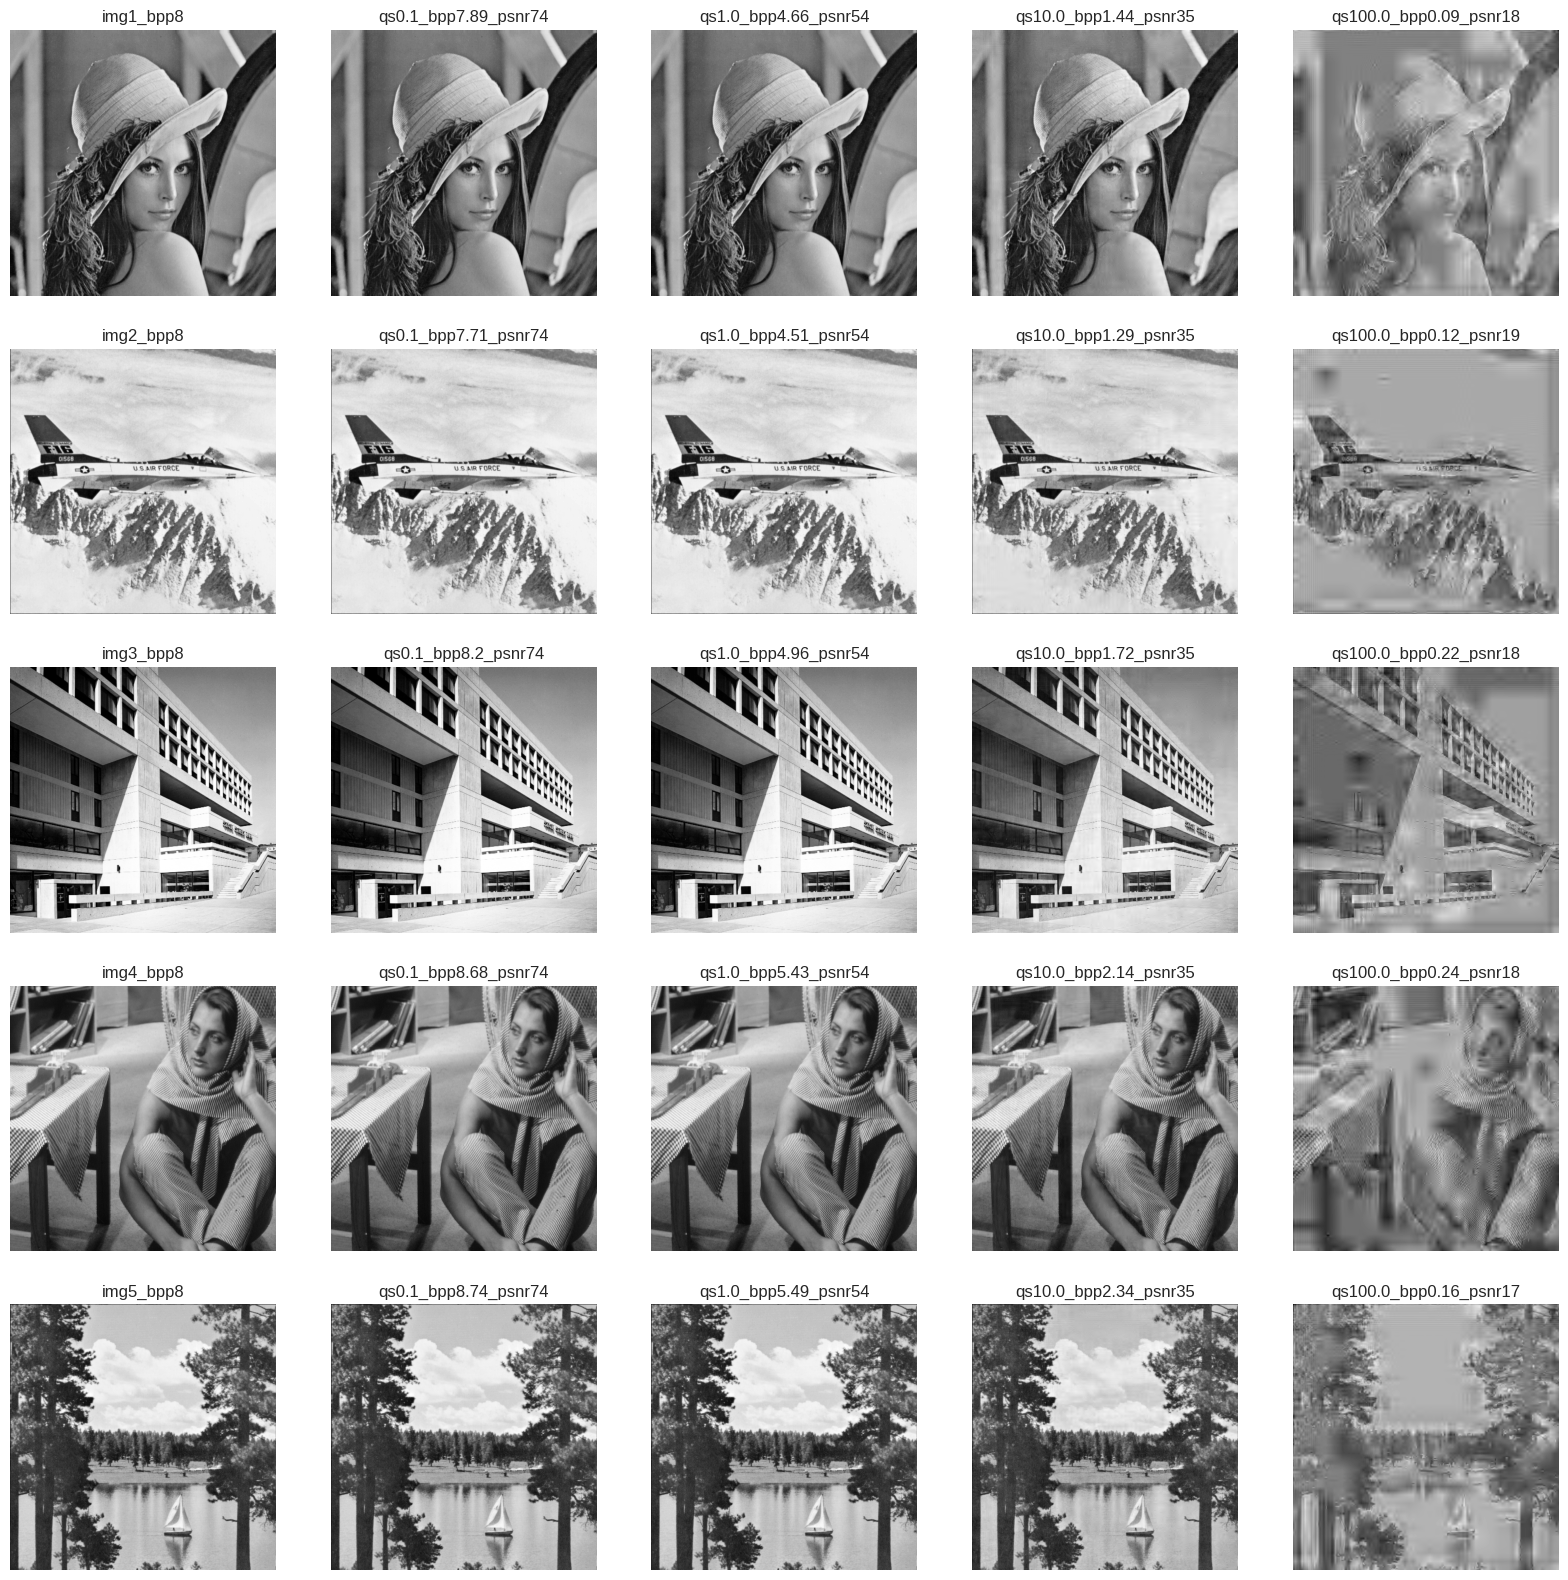

In [ ]:
# plot a 5*5 image
plt.figure(figsize=(20, 20))
for i in range(5):
    for j in range(5):
        plt.subplot(5, 5, i*5+j+1)
        # whiteboard style
        plt.axis('off')
        plt.imshow(img_list[i][j], cmap='gray')
        if psnr_list[i][j] == 'inf':
            plt.title('img'+str(i+1)+'_bpp'+str(bpp_list[i][j]))
        else:
            plt.title('qs'+str(round(quant_step_list_sample[j],2))+'_bpp'+str(round(bpp_list[i][j],2))+'_psnr'+str(int(psnr_list[i][j])))
# save
plt.savefig('5x5.svg', format='svg')